In [1]:
import io
import gzip

import pandas
import requests
import networkx

import eutility
import cooccurrence

In [3]:
# Read MeSH terms to MeSH names
url = 'https://raw.githubusercontent.com/dhimmel/mesh/e561301360e6de2140dedeaa7c7e17ce4714eb7f/data/terms.tsv'
mesh_df = pandas.read_table(url)

# Read MeSH terms mapped to DO Slim terms
url = 'https://raw.githubusercontent.com/dhimmel/disease-ontology/72614ade9f1cc5a5317b8f6836e1e464b31d5587/data/xrefs-slim.tsv'
doslim_xref_df = pandas.read_table(url)
doslim_xref_df = doslim_xref_df[doslim_xref_df.resource == 'MSH'][['doid_code', 'doid_name', 'resource_id']].rename(columns={'resource_id': 'mesh_id'})
disease_df = doslim_xref_df.merge(mesh_df)
disease_df.to_csv('data/DO-slim-to-mesh.tsv', sep='\t', index=False)
len(disease_df)

135

# Diseases

In [4]:
rows_out = list()

for i, row in disease_df.iterrows():
    term_query = '{disease}[MeSH Major Topic]'.format(disease = row.mesh_name.lower())
    payload = {'db': 'pubmed', 'term': term_query}
    pmids = eutility.esearch_query(payload, retmax = 10000)
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids)
    rows_out.append(row)
    print('{} articles for {}'.format(len(pmids), row.mesh_name))

disease_pmids_df = pandas.DataFrame(rows_out)

7213 articles for Hematologic Neoplasms
98558 articles for Brain Neoplasms
137542 articles for Lung Neoplasms
49057 articles for Kidney Neoplasms
45600 articles for Pancreatic Neoplasms
84831 articles for Skin Neoplasms
82879 articles for Bone Neoplasms
21863 articles for Pharyngeal Neoplasms
53403 articles for Ovarian Neoplasms
186325 articles for Breast Neoplasms
48809 articles for Glioma
88187 articles for Uterine Neoplasms
18395 articles for Adrenal Gland Neoplasms
33026 articles for Esophageal Neoplasms
12025 articles for Salivary Gland Neoplasms
82041 articles for Prostatic Neoplasms
63673 articles for Stomach Neoplasms
37244 articles for Urinary Bladder Neoplasms
14661 articles for Peripheral Nervous System Neoplasms
32853 articles for Thyroid Neoplasms
96367 articles for Liver Neoplasms
49717 articles for Uterine Cervical Neoplasms
3492 articles for Vaginal Neoplasms
207845 articles for Head and Neck Neoplasms
32455 articles for Rectal Neoplasms
28541 articles for Eye Neoplasms

In [5]:
with gzip.open('data/disease-pmids.tsv.gz', 'w') as write_file:
    write_file = io.TextIOWrapper(write_file)
    disease_pmids_df.to_csv(write_file, sep='\t', index=False)

# Symptoms

In [24]:
# Read MeSH Symptoms
url = 'https://raw.githubusercontent.com/dhimmel/mesh/e561301360e6de2140dedeaa7c7e17ce4714eb7f/data/symptoms.tsv'
symptom_df = pandas.read_table(url)
symptom_df.head()

,mesh_id,mesh_name,in_hsdn
0,D000006,"Abdomen, Acute",1
1,D000270,Adie Syndrome,0
2,D000326,Adrenoleukodystrophy,0
3,D000334,Aerophagy,1
4,D000370,Ageusia,1


In [ ]:
rows_out = list()

for i, row in symptom_df.iterrows():
    term_query = '{symptom}[MeSH Terms:noexp]'.format(symptom = row.mesh_name.lower())
    payload = {'db': 'pubmed', 'term': term_query}
    pmids = eutility.esearch_query(payload, retmax = 5000, sleep=2)
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids)
    rows_out.append(row)
    print('{} articles for {}'.format(len(pmids), row.mesh_name))

In [41]:
symptom_pmids_df = pandas.DataFrame(rows_out)

with gzip.open('data/symptom-pmids.tsv.gz', 'w') as write_file:
    write_file = io.TextIOWrapper(write_file)
    symptom_pmids_df.to_csv(write_file, sep='\t', index=False)

symptom_pmids_df.head()

,mesh_id,mesh_name,in_hsdn,term_query,n_articles,pubmed_ids
0,D000006,"Abdomen, Acute",1,"abdomen, acute[MeSH Terms:noexp]",8465,25669229|25650451|25619050|25608417|25543890|2...
1,D000270,Adie Syndrome,0,adie syndrome[MeSH Terms:noexp],311,24995781|24625775|24215593|23952008|23809464|2...
2,D000326,Adrenoleukodystrophy,0,adrenoleukodystrophy[MeSH Terms:noexp],1506,25583825|25378668|25297370|25275259|25149411|2...
3,D000334,Aerophagy,1,aerophagy[MeSH Terms:noexp],260,25073665|24796405|23772202|23772201|23636521|2...
4,D000370,Ageusia,1,ageusia[MeSH Terms:noexp],220,24825557|24782205|24191925|24137848|24088167|2...


# Cooccurrence

In [6]:
def read_pmids_tsv(path, key, min_articles = 1):
    term_to_pmids = dict()
    pmids_df = pandas.read_table(path, compression='gzip')
    pmids_df = pmids_df[pmids_df.n_articles >= min_articles]
    for i, row in pmids_df.iterrows():
        term = row[key]
        pmids = row.pubmed_ids.split('|')
        term_to_pmids[term] = set(pmids)
    pmids_df.drop('pubmed_ids', axis=1, inplace=True)
    return pmids_df, term_to_pmids

In [7]:
symptom_df, symptom_to_pmids = read_pmids_tsv('data/symptom-pmids.tsv.gz', key='mesh_id')
disease_df, disease_to_pmids = read_pmids_tsv('data/disease-pmids.tsv.gz', key='doid_code')

In [8]:
symptom_pmids = set.union(*symptom_to_pmids.values())
len(symptom_pmids)

1741776

In [9]:
disease_pmids = set.union(*disease_to_pmids.values())
len(disease_pmids)

3686312

In [10]:
cooc_df = cooccurrence.score_pmid_cooccurrence(disease_to_pmids, symptom_to_pmids, 'doid_code', 'mesh_id')

Total articles containing a doid_code: 3686312
Total articles containing a mesh_id: 1741776
Total articles containing both a doid_code and mesh_id: 405539

After removing terms without any cooccurences:
+ 133 doid_codes remain
+ 426 mesh_ids remain

Cooccurrence scores calculated for 56658 doid_code -- mesh_id pairs


In [11]:
cooc_df = symptom_df[['mesh_id', 'mesh_name']].merge(cooc_df)
cooc_df = disease_df[['doid_code', 'doid_name']].merge(cooc_df)
cooc_df = cooc_df.sort(['doid_name', 'p_fisher'])
cooc_df.to_csv('data/disease-symptom-cooccurrence.tsv', index=False, sep='\t')
cooc_df.head()

,doid_code,doid_name,mesh_id,mesh_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher
31170,DOID:10652,Alzheimer's disease,D004314,Down Syndrome,800,31.340068,25.526428,45.694983,0.000000e+00
31260,DOID:10652,Alzheimer's disease,D008569,Memory Disorders,1564,66.801960,23.412487,47.098472,0.000000e+00
31304,DOID:10652,Alzheimer's disease,D011595,Psychomotor Agitation,331,13.502524,24.513936,39.286225,0.000000e+00
31109,DOID:10652,Alzheimer's disease,D000647,Amnesia,303,12.408109,24.419515,38.858995,4.940656e-324
31233,DOID:10652,Alzheimer's disease,D006816,Huntington Disease,251,10.617248,23.640778,36.650552,4.011670e-264


In [12]:
import numpy
import scipy
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline

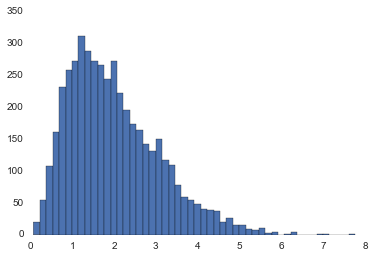

In [13]:
sig_df = cooc_df[cooc_df.p_fisher < 0.05]
plt.hist(list(numpy.log(sig_df.enrichment)), bins = 50);